In [1]:
import fasttext
import pandas as pd
import os
from huggingface_hub import hf_hub_download

In [46]:
from config import m2m_lang_mapping
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

### Download and load the model

In [3]:
# Download models if not already present
local_files = f"{os.getcwd()}/models"
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", 
                             cache_dir=local_files, filename="model.bin")

print("model path: ", model_path)
# Load the model
model = fasttext.load_model(model_path)


model path:  /Users/hassanghalib/Drive1/MACOS/MyWork/CustomerAnalytics/Repositories/lang_detect_analysis/models/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin


In [31]:
ls_undetected_lang_code = set()
ls_error_reviews = []

def predict(text, model_obj):
    pred_label = None
    short_code = None
    try:
        r = model_obj.predict(text)
        pred_label = r[0][0]    
        short_code = m2m_lang_mapping[pred_label]
        return short_code
    except Exception as ex:
        print(f"Unable to Detect langauge: {text}  {ex}")
        ls_undetected_lang_code.add(pred_label)
        ls_error_reviews.append(text)
    
    return None

def plot(df_data, log=True):
       # Initialize the matplotlib figure
       f, ax = plt.subplots(figsize=(8, 8))

       # Plot the total crashes
       sns.set_color_codes("pastel")
       sns.barplot(x="count", y="language", data=df_data,
              label="Number of Reviews", color="b")

       ax.legend(ncol=2, loc="lower right", frameon=True)
       if log:
        plt.xscale('log')
       ax.set(ylabel="",
              xlabel="Number of reviews and their detected langauge")
       sns.despine(left=True, bottom=True)
    

### Load sample review dataset

In [90]:
# Load the sample dataset

# NOTE
# prev_detect_lang: It contains system detected language of the review which may be wrong sometimes
# text: It contains original review

df = pd.read_csv("data/user_reviews.csv")
# Take only first two letters of the previous langauge
df["prev_detected_lang"] = df["prev_detected_lang"].map(lambda x: x[:2])

# Remove punctuation from the text
df["cleaned_text"] = df["text"].replace(to_replace=r'[^\w\s]', value='', regex=True)
df["cleaned_text"] = df["cleaned_text"].str.strip(" ")

df["cleaned_text_n_words"] = df["cleaned_text"].map(lambda x: len(x.split(' ')) if len(x) else 0)
df["cleaned_text_n_char"] = df["cleaned_text"].map(lambda x: len(x))

print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72283 entries, 0 to 72282
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   prev_detected_lang    72283 non-null  object
 1   text                  72283 non-null  object
 2   cleaned_text          72283 non-null  object
 3   cleaned_text_n_words  72283 non-null  int64 
 4   cleaned_text_n_char   72283 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.8+ MB
None


,prev_detected_lang,text,cleaned_text,cleaned_text_n_words,cleaned_text_n_char
0,ar,Exceptional.,Exceptional,1,11
1,ar,Superb.,Superb,1,6
2,ar,Exceptional.,Exceptional,1,11
3,ar,Pleasant.,Pleasant,1,8
4,ar,Superb.,Superb,1,6
5,ar,Exceptional.,Exceptional,1,11
6,ar,Exceptional.,Exceptional,1,11
7,de,Superb.,Superb,1,6
8,ar,Very good.,Very good,2,9
9,ar,Exceptional.,Exceptional,1,11


### Set of unique short-sentences/words in the dataset

You can observe that almost all of the words are in english

In [80]:
df["text"].unique()

array(['Exceptional.', 'Superb.', 'Pleasant.', 'Very good.', 'Good.',
       'Passable.', 'Bad.', 'Disappointing.', 'Very poor.', 'Poor.',
       'Very Good.', 'Excellent.', 'Super.', 'Wonderful !!!.', 'Perfect.',
       'Recomendable.', 'excellent.', 'Fabulous.', 'Really lovely.',
       'good.', 'Confortable.', 'nice.', 'Doha 2021.', 'Fantastic.',
       'Great.', 'Okay.', 'Very very good 😊.', 'Thanks.', 'Amazing.',
       'thanks.', 'perfect.', 'Perfect stay.', 'LOVELY HOTEL.',
       'very nice.', 'Truly amazing!.', 'so good.', 'fantastic.',
       'superb hotel.', 'Awesome!.', 'Perfect👍👍👍.', 'Awesome !!!.',
       'Perfect👌.', 'nice hotel.', 'perfect!!.'], dtype=object)

In [81]:
df["predicted_lang"] = df["cleaned_text"].map(lambda t: predict(t, model) if len(t) else None)

Unable to Detect langauge: Okay  '__label__war_Latn'
Unable to Detect langauge: Okay  '__label__war_Latn'
Unable to Detect langauge: Okay  '__label__war_Latn'


In [9]:
print(len(ls_undetected_lang_code), len(ls_error_reviews))
ls_undetected_lang_code

1 3


{'__label__war_Latn'}

### Distribution of Previously detected Languages

These are the languages detected by the review-platform. These languages were detected by their model using text and some other features related to the demographics of the reviewer.

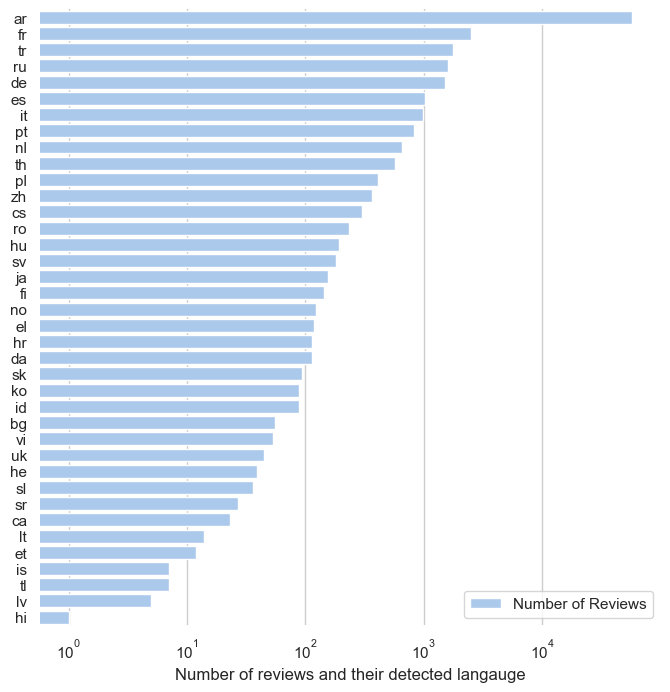

In [82]:
lang_counts = df["prev_detected_lang"].value_counts()
df_prev_lang_c = pd.DataFrame(data={'language': lang_counts.index, "count": lang_counts.values})
plot(df_prev_lang_c)


<font color='red'> **While almost all of the sentences in the dataset are in english, But the language detected by review-platform has not marked any of the sentence as "en"**. See the above plot.</font>

### Distribution of lagnauges detected by the FASTTEXT

These are the languages detected by the fasttext model.

predicted_lang
en    58636
de    13636
ro        4
fr        2
cs        1
id        1
Name: count, dtype: int64


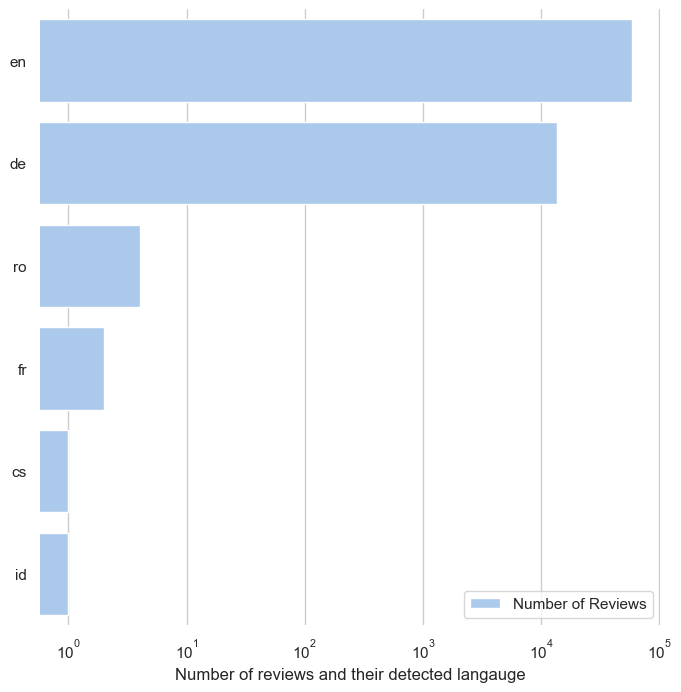

In [83]:
lang_counts2 = df["predicted_lang"].value_counts()
df_pred_lang_c = pd.DataFrame(data={'language': lang_counts2.index, "count": lang_counts2.values})

print(lang_counts2)

plot(df_pred_lang_c)

<font color='red'> **From the value-count and plot above we can see that fasttext has detected most of the sentences as 'en'. But there are problems with the 'de' language though. The count of words marked as 'de' is high. We have to see further which words are marked as 'de' or any other non-english language .**</font>

### Words marked as English

In [88]:
print("word,  number of reviews\n")
pprint(df[df["predicted_lang"] == 'en']["cleaned_text"].value_counts())

word,  number of reviews

cleaned_text
Exceptional       32214
Very good         12349
Good               6135
Pleasant           2876
Passable           2675
Disappointing      1060
Poor                836
Very poor           454
Fabulous              6
Perfect               4
perfect               3
Amazing               2
good                  2
Awesome               2
Super                 2
thanks                1
fantastic             1
so good               1
Truly amazing         1
very nice             1
Perfect stay          1
Very Good             1
excellent             1
Recomendable          1
Thanks                1
Very very good        1
Great                 1
Fantastic             1
Confortable           1
Wonderful             1
Really lovely         1
Name: count, dtype: int64


### Words NOT marked as English

In [89]:
print("word,  number of reviews\n")

pprint(df[df["predicted_lang"] != 'en']["cleaned_text"].value_counts())


word,  number of reviews

cleaned_text
Superb          11382
Bad              2253
nice                3
Okay                3
Excellent           2
Doha 2021           1
LOVELY HOTEL        1
superb hotel        1
nice hotel          1
Name: count, dtype: int64


Language for the word "Superb" and "Bad" where wrongly predicted and are noticeable.